In [4]:
import anndata as ad
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
%load_ext autoreload

from scipy.stats import pearsonr

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
ad1 = ad.read_h5ad("/Users/kandarpjoshi/projects/spacehack3/spatial_compare/data/CJ_BG_mini1.h5ad")
ad2 = ad.read_h5ad("/Users/kandarpjoshi/projects/spacehack3/spatial_compare/data/CJ_BG_mini2.h5ad")
ad3 = ad.read_h5ad("/Users/kandarpjoshi/projects/spacehack3/spatial_compare/data/CJ_BG_mini3.h5ad")
ad4 = ad.read_h5ad("/Users/kandarpjoshi/projects/spacehack3/spatial_compare/data/CJ_BG_mini4.h5ad")

combined_reference = pd.concat([ad1.obs,ad2.obs, ad3.obs, ad4.obs], axis=0)

In [55]:
def spatial_detection_scores(
    reference: pd.DataFrame,
    query: pd.DataFrame,
    plot_stuff=True,
    query_name: str = "query data",
    comparison_column="transcript_counts",
    category="supercluster_name",
    n_bins=50,
    in_place=True,
    non_spatial=False,
):
    """
    Calculate and plot spatial detection scores for query data compared to reference data.

    Parameters:
        reference (pd.DataFrame): The reference data.
        query (pd.DataFrame): The query data.
        plot_stuff (bool, optional): Whether to plot the results. Defaults to True.
        query_name (str, optional): The name of the query data. Defaults to "query data".
        category (str, optional): The category column to compare. Defaults to "supercluster_name".
        n_bins (int, optional): The number of bins for spatial grouping. Defaults to 50.
        in_place (bool, optional): Whether to modify the query data in place. Defaults to True.
        non_spatial (bool, optional): Whether to compare to an ungrouped mean/std. Defaults to False.

    Returns:
        dict: A dictionary containing the bin image, extent, query data, and reference data (if in_place is False).
    """
    # code goes here

    if category not in reference.columns or category not in query.columns:
        raise ValueError("category " + category + " not in reference and query inputs")

    shared_category_values = list(
        set(reference[category].unique()) & set(query[category].unique())
    )
    if (
        len(shared_category_values) < query[category].unique().shape[0]
        or len(shared_category_values) < reference[category].unique().shape[0]
    ):
        in_place = False

    if in_place:
        s2 = query.loc[query[category].isin(shared_category_values), :]
        s1 = reference.loc[reference[category].isin(shared_category_values), :]
    else:
        s2 = query.loc[query[category].isin(shared_category_values), :].copy()
        s1 = reference.loc[reference[category].isin(shared_category_values), :].copy()

    means = s1.groupby(category, observed=True)[comparison_column].mean()
    stds = s1.groupby(category, observed=True)[comparison_column].std()

    # if you want to compare to an ungrouped mean/std, try this:
    if non_spatial:
        means[:] = means.mean()
        stds[:] = stds.mean()

    s2["detection_relative_z_score"] = 0.0
    s2["detection_difference"] = 0.0
    s2["detection_ratio"] = 0.0

    for c, gb in s2.groupby(category, observed=True):
        if c not in shared_category_values:
            continue

        s2.loc[s2[category] == c, ["detection_relative_z_score"]] = (
            (s2.loc[s2[category] == c, [comparison_column]] - means[c]) / stds[c]
        ).values
        s2.loc[s2[category] == c, ["detection_difference"]] = (
            s2.loc[s2[category] == c, [comparison_column]] - means[c]
        ).values
        s2.loc[s2[category] == c, ["log_10_detection_ratio"]] = np.log10(
            (s2.loc[s2[category] == c, [comparison_column]] / means[c]).values
        )

    s2["xy_bucket"] = list(
        zip(
            pd.cut(s2.x_centroid, n_bins, labels=list(range(n_bins))),
            pd.cut(s2.y_centroid, n_bins, labels=list(range(n_bins))),
        )
    )

    binx = s2.groupby("xy_bucket").x_centroid.mean()
    biny = s2.groupby("xy_bucket").y_centroid.mean()

    z_score = s2.groupby("xy_bucket").detection_relative_z_score.mean()
    difference = s2.groupby("xy_bucket").detection_difference.mean()
    log_ratio = s2.groupby("xy_bucket").log_10_detection_ratio.mean()
    n_cells = s2.groupby("xy_bucket").x_centroid.count()

    bin_image_z_score = np.zeros([n_bins, n_bins])
    bin_image_difference = np.zeros([n_bins, n_bins])
    bin_image_ratio = np.zeros([n_bins, n_bins])
    bin_image_counts = np.zeros([n_bins, n_bins])

    extent = [np.min(binx), np.max(binx), np.min(biny), np.max(biny)]
    for coord in binx.index:
        bin_image_z_score[coord[1], coord[0]] = z_score[coord]
        bin_image_difference[coord[1], coord[0]] = difference[coord]
        bin_image_ratio[coord[1], coord[0]] = log_ratio[coord]
        bin_image_counts[coord[1], coord[0]] = n_cells[coord]

    if plot_stuff:
        if non_spatial:
            title_string = "Non-spatial Detection Scores"
        else:
            title_string = "Spatial Detection Scores"
        min_maxes = {
            "detection z-score": [bin_image_z_score, [-1, 1]],
            "total counts difference": [bin_image_difference, [-100, 100]],
            "log10(detection ratio)": [bin_image_ratio, [-1, 1]],
        }

        fig, axs = plt.subplots(1, 3, figsize=[15, 5])
        if non_spatial:
            fig.suptitle(title_string + "\n" + query_name)
        else:
            fig.suptitle(
                title_string
                + "\n"
                + query_name
                + " grouped by "
                + category
                + " and spatially binned"
            )
        for ii, plot_name in enumerate(min_maxes.keys()):
            ax = axs[ii]
            pcm = ax.imshow(
                min_maxes[plot_name][0],
                extent=extent,
                cmap="coolwarm_r",
                vmin=min_maxes[plot_name][1][0],
                vmax=min_maxes[plot_name][1][1],
            )
            fig.colorbar(pcm, ax=ax, shrink=0.7)
            ax.set_title(query_name + "\n" + plot_name)

    result = {
        "z_score_image": bin_image_z_score,
        "difference_image": bin_image_difference,
        "ratio_image": bin_image_ratio,
        "extent": extent,
        "count_image": bin_image_counts,
        "query": True,
        "reference": True,
    }

    if not in_place:
        result.update({"query": s2, "reference": s1})

    return result

In [60]:
def label_composition_test(reference, query, category, detection_score_column, n_bins=50):
    """
    Calculate the number of labels from a specified category in each bin
    and plot a correlation between label frequency and detection scores per bin.

    Parameters:
        reference (pd.DataFrame): The reference data.
        query (pd.DataFrame): The query data.
        category (str): The category column to consider for label frequency.
        detection_score_column (str): The detection score column to correlate against.
        n_bins (int, optional): Number of spatial bins. Defaults to 50.

    Returns:
        dict: A dictionary with binned label frequencies, mean detection scores, and correlation results.
    """
    if category not in query.columns or detection_score_column not in query.columns:
        raise ValueError("Ensure both 'category' and 'detection_score_column' are in the query data.")

    query["xy_bucket"] = list(
        zip(
            pd.cut(query.x_centroid, n_bins, labels=list(range(n_bins))),
            pd.cut(query.y_centroid, n_bins, labels=list(range(n_bins))),
        )
    )

    binx = query.groupby("xy_bucket").x_centroid.mean()
    biny = query.groupby("xy_bucket").y_centroid.mean()
        
    unique_label_frequency = (
        query.groupby("xy_bucket")[category].nunique()
    )  # Number of unique labels per bin

    label_frequency = (
        query.groupby("xy_bucket")[category].count()
    )  # Number of unique labels per bin
    
    mean_detection_scores = (
        query.groupby("xy_bucket")[detection_score_column].mean()
    )

    bin_stats = pd.DataFrame({
        "label_frequency": label_frequency,
        "mean_detection_score": mean_detection_scores,
    })

    correlation, p_value = pearsonr(
        bin_stats["label_frequency"], bin_stats["mean_detection_score"]
    ) #calculate correlation between label frequency and detection score

    plt.figure(figsize=(8, 6))
    sns.regplot(
        x="label_frequency", 
        y="mean_detection_score", 
        data=bin_stats, 
        scatter_kws={"s": 50}, 
        line_kws={"color": "red"},
    )
    plt.title(f"Correlation Between Label Frequency and {detection_score_column}\n(r={correlation:.2f}, p={p_value:.2e})")
    plt.xlabel("Label Frequency per Bin")
    plt.ylabel("Mean Detection Score per Bin")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(bin_stats["label_frequency"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Histogram of Label counts")
    plt.xlabel("Label counts per bin")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
    
    return {
        "bin_stats": bin_stats,
        "correlation": correlation,
        "p_value": p_value,
    }


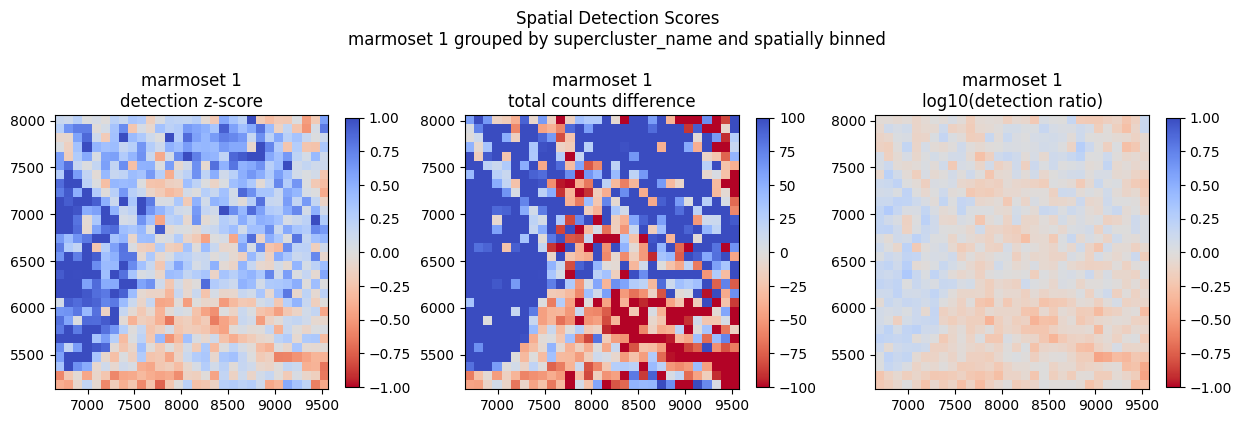

In [53]:
s = spatial_detection_scores (combined_reference, ad1.obs, query_name="marmoset 1", n_bins=30,non_spatial=False)

In [63]:
s['query']

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,...,supercluster_name,cluster_name,subcluster_name,acquisition_date,unique_acquisition_date,detection_relative_z_score,detection_difference,detection_ratio,log_10_detection_ratio,xy_bucket
672371,aefbgcpn-1,9237.635742,5091.179688,3315,0,0,0,3,0,3318,...,Upper-layer intratelencephalic,ULIT_130,ULIT_130_2782,20240808,20240808_00,4.116701,2481.619917,0.0,0.599640,"(26, 0)"
672384,aefeidpe-1,9060.008789,5100.595703,511,0,0,0,0,0,511,...,Deep-layer intratelencephalic,DLIT_144,DLIT_144_2717,20240808,20240808_00,-0.630877,-334.083496,0.0,-0.218479,"(24, 0)"
672385,aefekpib-1,9108.054688,5096.673828,547,0,0,0,1,0,548,...,MGE interneuron,MGE_251,MGE_251_282,20240808,20240808_00,-0.303031,-137.853230,0.0,-0.097610,"(24, 0)"
672386,aefenpih-1,9112.100586,5091.402832,203,0,0,0,0,0,203,...,MGE interneuron,MGE_250,MGE_250_283,20240808,20240808_00,-1.059215,-481.853230,0.0,-0.528101,"(24, 0)"
672393,aefiaeae-1,8892.549805,5865.926758,524,0,0,0,0,0,524,...,MGE interneuron,MGE_254,MGE_254_209,20240808,20240808_00,-0.353589,-160.853230,0.0,-0.116266,"(22, 7)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863049,oilgigmc-1,6619.080566,7679.040527,75,0,0,0,0,0,75,...,Microglia,Mgl_11,Mgl_11_3286,20240808,20240808_00,-0.818177,-52.082816,0.0,-0.229026,"(0, 25)"
863050,oilhjimd-1,7187.359375,7600.927734,128,0,0,0,0,0,128,...,Microglia,Mgl_11,Mgl_11_3290,20240808,20240808_00,0.014408,0.917184,0.0,0.003123,"(5, 25)"
863051,oiljljcg-1,6742.385254,7688.654297,84,0,0,0,0,0,84,...,Medium spiny neuron,MSN_221,MSN_221_2092,20240808,20240808_00,-1.545885,-498.626338,0.0,-0.841111,"(1, 25)"
863061,oimbokkg-1,7050.512207,7648.844727,193,0,0,0,0,0,193,...,Medium spiny neuron,MSN_211,MSN_211_2072,20240808,20240808_00,-1.207954,-389.626338,0.0,-0.479833,"(4, 25)"


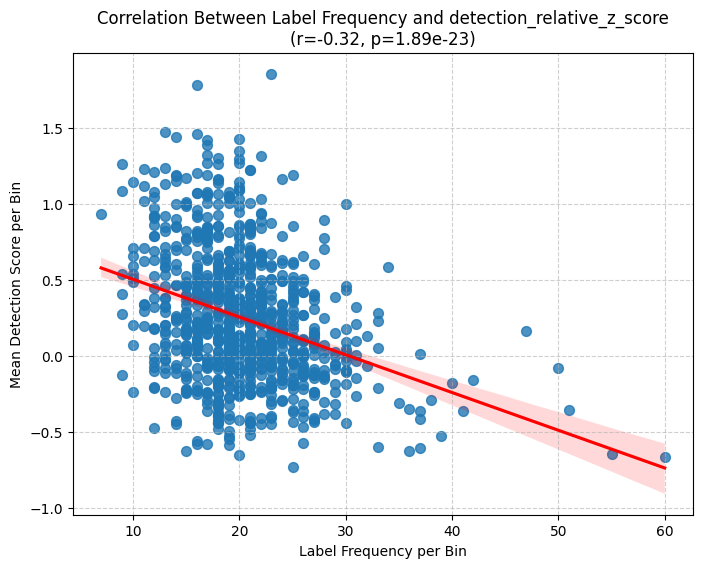

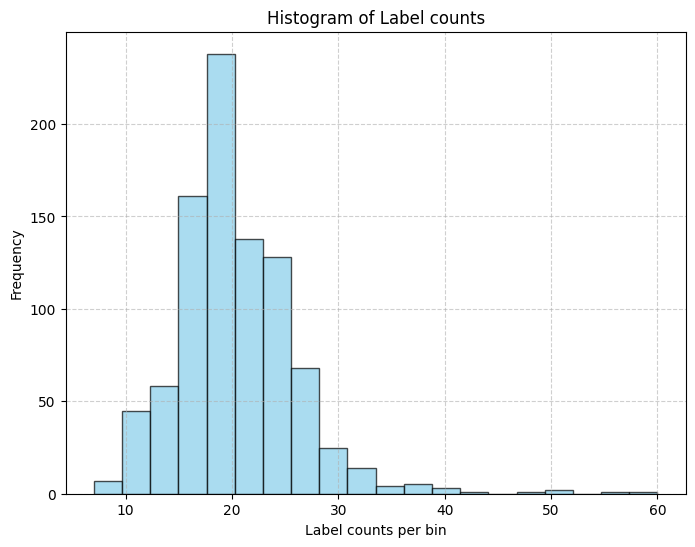

In [61]:
lc = label_composition_test (combined_reference, s['query'], category="supercluster_name", detection_score_column="detection_relative_z_score", n_bins=30)

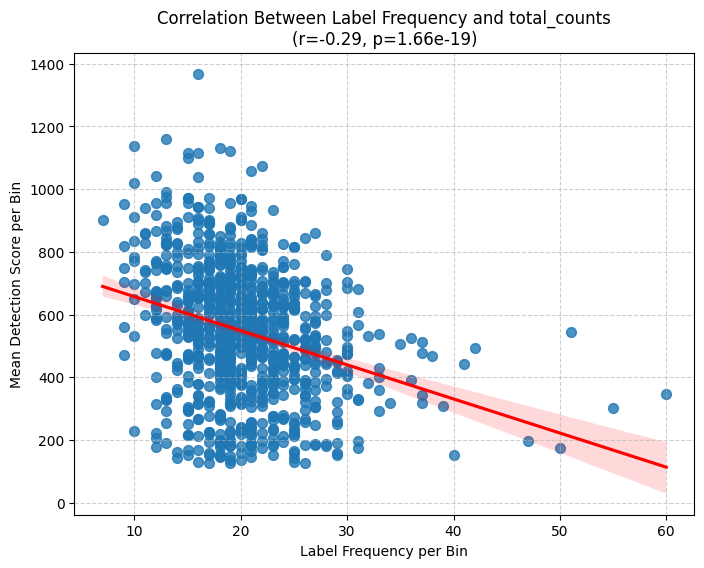

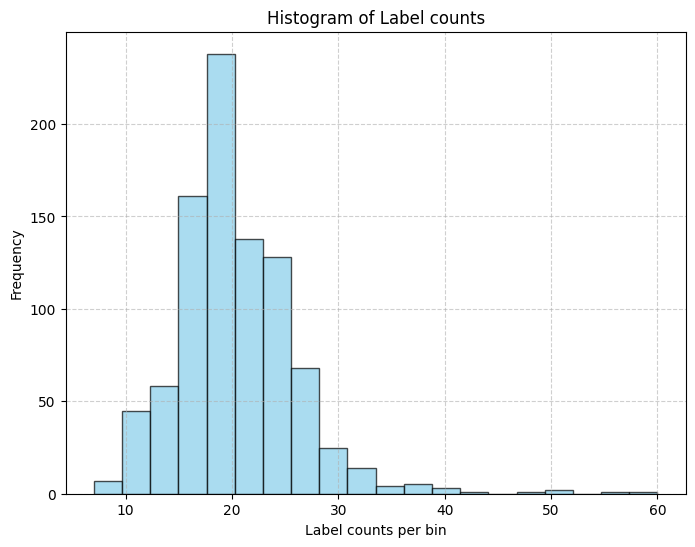

In [62]:
lc = label_composition_test (combined_reference, s['query'], category="supercluster_name", detection_score_column="total_counts", n_bins=30)

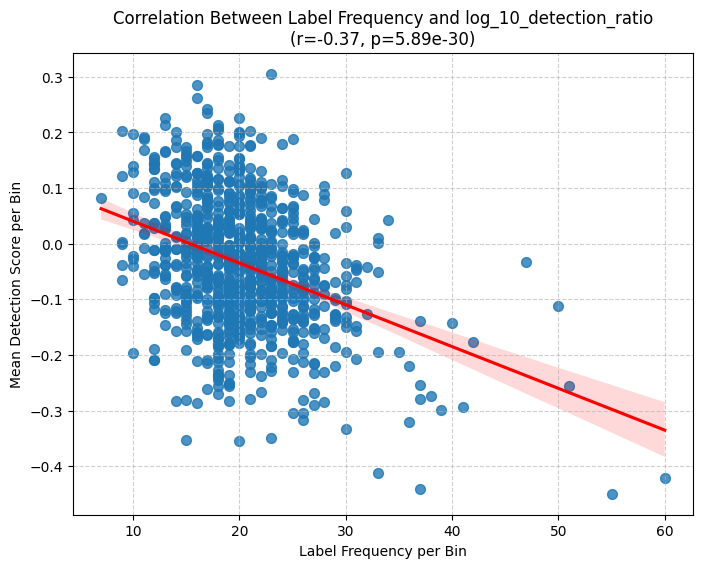

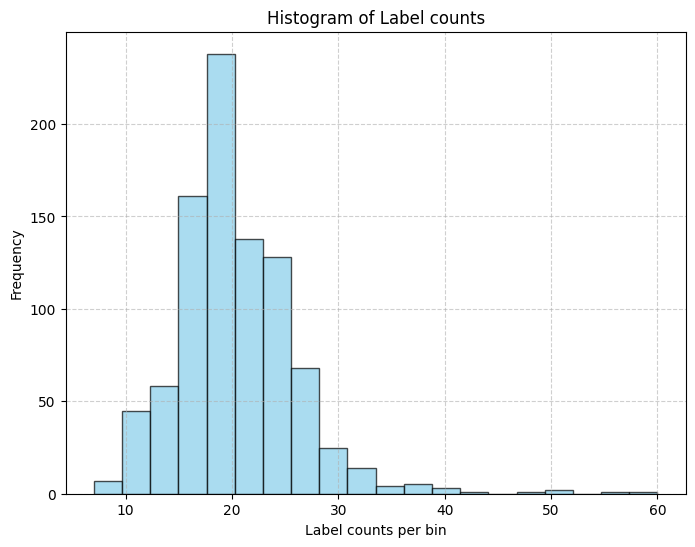

In [64]:
lc = label_composition_test (combined_reference, s['query'], category="supercluster_name", detection_score_column="log_10_detection_ratio", n_bins=30)